Found existing installation: scikeras 0.13.0
Uninstalling scikeras-0.13.0:
  Successfully uninstalled scikeras-0.13.0
Found existing installation: scikit-learn 1.4.2
Uninstalling scikit-learn-1.4.2:
  Successfully uninstalled scikit-learn-1.4.2
  Using cached scikeras-0.13.0-py3-none-any.whl.metadata (3.1 kB)
  Using cached scikit_learn-1.4.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached scikeras-0.13.0-py3-none-any.whl (26 kB)
Using cached scikit_learn-1.4.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.1 MB)


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Mejores hiperparámetros: {'batch_size': 16, 'epochs': 100, 'model__dropout_rate': 0.2, 'model__l2_reg': 0.0, 'model__learning_rate': 0.001, 'model__n_hidden': 1, 'model__n_neurons': 32}
accuracy promedio: 0.9824
f1 promedio: 0.9859
precision promedio: 0.9861
recall promedio: 0.9860
roc_auc promedio: 0.9956


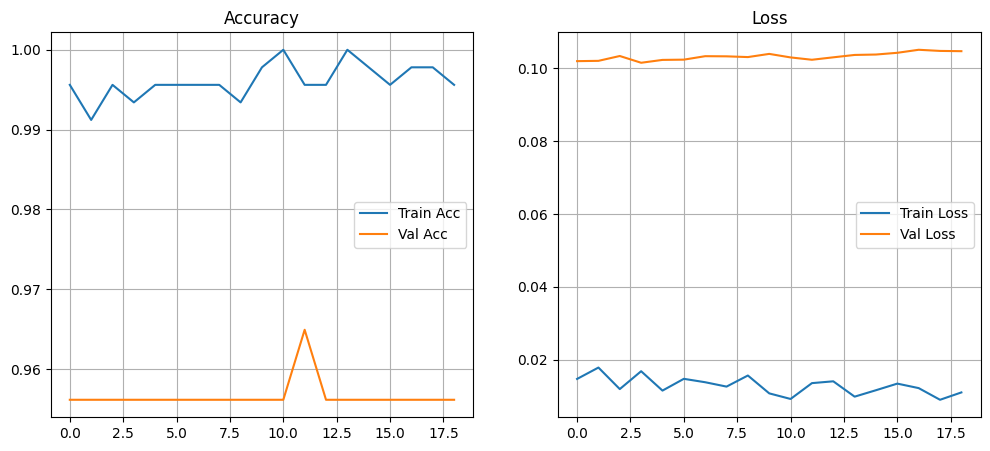

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Accuracy: 0.956140350877193

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.98      0.94        42
           1       0.99      0.94      0.96        72

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114



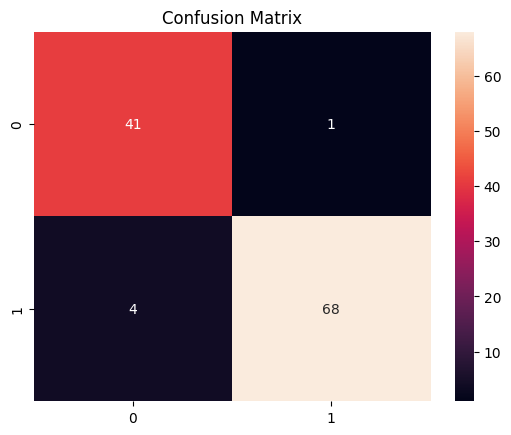

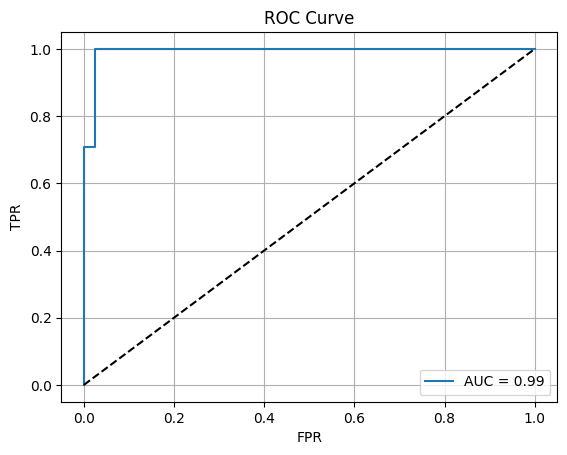

In [1]:
# Uninstall problematic packages to ensure a clean slate
!pip uninstall -y scikeras scikit-learn

# Install scikeras (latest stable) and a SPECIFIC, known-good stable scikit-learn version
# As of now, scikeras 0.13.0 works well with scikit-learn 1.4.2
!pip install scikeras==0.13.0 scikit-learn==1.4.2

# After running this cell, make sure to RESTART YOUR COLAB RUNTIME
# Go to Runtime -> Restart runtime

# Then, you can run the rest of your code from the beginning.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

# Cargar dataset
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

# División y escalado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ============================
# 2. Modelo con Keras Functional API
# ============================

from scikeras.wrappers import KerasClassifier
from tensorflow import keras
from keras import layers, Input, regularizers

def build_classifier(n_hidden=2, n_neurons=32, learning_rate=0.01, dropout_rate=0.0, l2_reg=0.0):
    input_layer = Input(shape=(X_train_scaled.shape[1],))
    x = input_layer
    for _ in range(n_hidden):
        x = layers.Dense(n_neurons, activation='relu',
                         kernel_regularizer=regularizers.l2(l2_reg))(x)
        if dropout_rate > 0:
            x = layers.Dropout(dropout_rate)(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs=input_layer, outputs=output)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', keras.metrics.AUC(name='auc')]
    )
    return model

# ============================
# 3. GridSearchCV
# ============================

keras_clf = KerasClassifier(model=build_classifier, verbose=0)

param_grid = {
    "model__n_hidden": [1, 2],
    "model__n_neurons": [32, 64],
    "model__learning_rate": [0.001, 0.01],
    "model__dropout_rate": [0.0, 0.2],
    "model__l2_reg": [0.0, 0.01],
    "batch_size": [16],
    "epochs": [100]
}

from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(keras_clf, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print("\nMejores hiperparámetros:", grid_search.best_params_)

# ============================
# 4. Validación cruzada con múltiples métricas
# ============================

best_clf = grid_search.best_estimator_
scoring = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc']
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_validate(best_clf, X_train_scaled, y_train, cv=cv, scoring=scoring)

for metric in scoring:
    print(f"{metric} promedio: {cv_results['test_' + metric].mean():.4f}")

# ============================
# 5. Entrenamiento final y visualización
# ============================

best_model = best_clf.model_
history = best_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=200,
    callbacks=[keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)],
    verbose=0
)

def plot_learning_curves(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.grid()
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.grid()
    plt.legend()
    plt.show()

plot_learning_curves(history)

# ============================
# 6. Evaluación
# ============================

proba_preds = best_model.predict(X_test_scaled).ravel()
preds = (proba_preds > 0.5).astype("int32")
print("\nAccuracy:", accuracy_score(y_test, preds))
print("\nClassification Report:\n", classification_report(y_test, preds))
sns.heatmap(confusion_matrix(y_test, preds), annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.show()

# AUC & ROC
auc_score = roc_auc_score(y_test, proba_preds)
fpr, tpr, thresholds = roc_curve(y_test, proba_preds)
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()